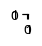

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
# pd.set_option("display.max_columns",999)
# pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from torch import optim
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, HLAS, AA_KEYS
from src.data_processing import get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_mean_pr_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance, get_roc
from src.sklearn_train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
from sklearn.ensemble import RandomForestClassifier

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

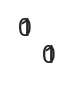

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

In [9]:
from joblib import Parallel, delayed
from functools import partial
import multiprocessing
import itertools
from src.data_processing import get_aa_properties, get_mutation_dataset
from sklearn.ensemble import RandomForestClassifier
from copy import deepcopy
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def bootstrap_wrapper(y_score, y_true, seed):
    np.random.seed(seed)
    sample_idx = np.random.randint(0, len(y_score), len(y_score))
    sample_score = y_score[sample_idx]
    sample_true = y_true[sample_idx]

    try:
        test_results = get_metrics(sample_true, sample_score)
    except:
        return pd.DataFrame(), (None, None, None, None)

    # Save to get mean curves after
    roc_curve = (test_results.pop('roc_curve'), test_results['auc'])
    # Same
    pr_curve = (test_results.pop('pr_curve'), test_results['prauc'])
    return pd.DataFrame(test_results, index=[0]), roc_curve


def bootstrap_eval(y_score, y_true, n_rounds=10000, n_jobs=16):
    wrapper = partial(bootstrap_wrapper,
                      y_score=y_score, y_true=y_true)
    print('Sampling')
    output = Parallel(n_jobs=n_jobs)(delayed(wrapper)(seed=seed) for seed in
                                     tqdm(range(n_rounds), desc='Bootstrapping rounds', position=1, leave=False))

    print('Making results DF and curves')
    result_df = pd.concat([x[0] for x in output])
    mean_roc_curve = get_mean_roc_curve([x[1] for x in output if x[1][0] is not None])
    # mean_pr_curve = get_mean_pr_curve([x[2] for x in output])
    return result_df, mean_roc_curve


def assert_encoding_kwargs(encoding_kwargs, mode_eval=False):
    """
    Assertion / checks for encoding kwargs and verify all the necessary key-values 
    are in
    """
    # Making a deep copy since dicts are mutable between fct calls
    encoding_kwargs = deepcopy(encoding_kwargs)
    if encoding_kwargs is None:
        encoding_kwargs = {'max_len': 12,
                           'encoding': 'onehot',
                           'blosum_matrix': None,
                           'standardize': False}
    essential_keys = ['max_len', 'encoding', 'blosum_matrix', 'standardize']
    assert all([x in encoding_kwargs.keys() for x in
                essential_keys]), f'Encoding kwargs don\'t contain the essential key-value pairs! ' \
                                  f"{'max_len', 'encoding', 'blosum_matrix', 'standardize'} are required."

    if mode_eval:
        if any([(x not in encoding_kwargs.keys()) for x in ['seq_col', 'hla_col', 'target_col', 'rank_col']]):
            if 'seq_col' not in encoding_kwargs.keys():
                encoding_kwargs.update({'seq_col': 'Peptide'})
            if 'hla_col' not in encoding_kwargs.keys():
                encoding_kwargs.update({'hla_col': 'HLA'})
            if 'target_col' not in encoding_kwargs.keys():
                encoding_kwargs.update({'target_col': 'agg_label'})
            if 'rank_col' not in encoding_kwargs.keys():
                encoding_kwargs.update({'seq_col': 'trueHLA_EL_rank'})

        # This KWARGS not needed in eval mode since I'm using Pipeline and Wrapper
        del encoding_kwargs['standardize']
    return encoding_kwargs


def get_predictions(df, models, ics_dict, encoding_kwargs):
    """
    Args:
        models (list) : list of all the models for a given fold. Should be a LIST
        ics_dict (dict): weights or None
        encoding_kwargs: the kwargs needed to process the df
        metrics (dict):

    Returns:
        predictions_df (pd
        df (pd.DataFrame): DataFrame containing the Peptide-HLA pairs to evaluate
        models (list): A.DataFrame): Original DataFrame + a column predictions which are the scores + y_true
    """

    df = df.copy()

    # HERE NEED TO DO SWITCH CASES
    x, y = get_mutation_dataset(df, ics_dict, **encoding_kwargs)

    # Take the first model in the list and get its class
    model_class = models[0].__class__

    # If model is a scikit-learn model, get pred prob
    # if issubclass(model_class, sklearn.base.BaseEstimator):
    average_predictions = [model.predict_proba(x)[:, 1] \
                           for model in models]

    average_predictions = np.mean(np.stack(average_predictions), axis=0)
    # assert len(average_predictions)==len(df), f'Wrong shapes passed preds:{len(average_predictions)},df:{len(df)}'
    output_df = df.copy(deep=True)
    output_df['pred'] = average_predictions
    return output_df


# TRAIN WITH PARALLEL WRAPPER
def parallel_inner_train_wrapper(train_dataframe, x_test, base_model, ics_dict,
                                 encoding_kwargs, standardize, fold_out, fold_in):
    seed = fold_out * 10 + fold_in
    # Copy the base model, resets the seed
    model = sklearn.base.clone(base_model)
    model.set_params(random_state=seed)
    if standardize:
        model = Pipeline([('scaler', StandardScaler()), ('model', model)])

    # Here resets model weight at every fold, using the fold number (range(0, n_folds*(n_folds-1)) ) as seed
    # Query subset dataframe and get encoded data and targets
    train = train_dataframe.query('fold != @fold_out and fold != @fold_in').reset_index(drop=True)
    valid = train_dataframe.query('fold == @fold_in').reset_index(drop=True)
    # Get datasets
    x_train, y_train = get_mutation_dataset(train, ics_dict, **encoding_kwargs)
    x_valid, y_valid = get_mutation_dataset(valid, ics_dict, **encoding_kwargs)

    # Fit the model and append it to the list
    model.fit(x_train, y_train)

    # Get the prediction values on both the train and validation set
    y_train_pred, y_train_score = model.predict(x_train), model.predict_proba(x_train)[:, 1]
    y_val_pred, y_val_score = model.predict(x_valid), model.predict_proba(x_valid)[:, 1]
    # Get the metrics and save them
    train_metrics = get_metrics(y_train, y_train_score, y_train_pred)
    valid_metrics = get_metrics(y_valid, y_val_score, y_val_pred)
    y_pred_test = model.predict_proba(x_test)[:, 1]

    return model, train_metrics, valid_metrics, y_pred_test


def nested_kcv_train_mut(dataframe, base_model, ics_dict, encoding_kwargs: dict = None, n_jobs=None):
    """
    Args:
        dataframe:
        base_model:
        ics_dict:
        encoding_kwargs:

    Returns:
        models_fold
        train_results
        test_results
    """
    encoding_kwargs = assert_encoding_kwargs(encoding_kwargs, mode_eval=False)
    #
    models_dict = {}
    test_metrics = {}
    train_metrics = {}
    folds = sorted(dataframe.fold.unique())
    std = encoding_kwargs.pop('standardize')
    for fold_out in tqdm(folds, leave=False, desc='Outer fold', position=2):
        # Get test set & init models list to house all models trained in inner fold
        test = dataframe.query('fold == @fold_out').reset_index(drop=True)
        x_test, y_test = get_mutation_dataset(test, ics_dict, **encoding_kwargs)
        # For a given fold, all the models that are trained should be appended to this list
        inner_folds = sorted([f for f in folds if f != fold_out])
        n_jobs = len(inner_folds) if n_jobs is None else n_jobs
        # Create the sub-dict and put the model into the models dict
        train_wrapper_ = partial(parallel_inner_train_wrapper, train_dataframe=dataframe, x_test=x_test,
                                 base_model=base_model, ics_dict=ics_dict, encoding_kwargs=encoding_kwargs,
                                 standardize=std, fold_out=fold_out)
        output = Parallel(n_jobs=n_jobs)(
            delayed(train_wrapper_)(fold_in=fold_in) for fold_in in tqdm(inner_folds,
                                                                         desc='Inner Folds',
                                                                         leave=False, position=1))
        models_dict[fold_out] = [x[0] for x in output]
        train_tmp = [x[1] for x in output]
        valid_tmp = [x[2] for x in output]
        avg_prediction = [x[3] for x in output]
        avg_prediction = np.mean(np.stack(avg_prediction), axis=0)
        train_metrics[fold_out] = {k: {'train': v_train,
                                       'valid': v_valid} for k, v_train, v_valid in
                                   zip(inner_folds, train_tmp, valid_tmp)}
        test_metrics[fold_out] = get_metrics(y_test, avg_prediction)

    return models_dict, train_metrics, test_metrics


# EVAL WITH PARALLEL WRAPPER
def parallel_eval_wrapper(test_dataframe, models_list, ics_dict,
                          train_dataframe, encoding_kwargs, fold_out):
    # If no train dataframe provided and test_dataframe is partitioned,
    # It will eval on each of the folds
    if 'fold' in test_dataframe.columns and test_dataframe.equals(train_dataframe):
        test_df = test_dataframe.query('fold==@fold_out')
    else:
        test_df = test_dataframe.copy().reset_index(drop=True)

    if train_dataframe is not None and not train_dataframe.equals(test_dataframe):
        tmp = train_dataframe.query('fold != @fold_out')
        train_peps = tmp[encoding_kwargs['seq_col']].unique()
        test_df = test_df.query(f'{encoding_kwargs["seq_col"]} not in @train_peps')

    predictions_df = get_predictions(test_df, models_list, ics_dict, encoding_kwargs)
    test_metrics = get_metrics(predictions_df[encoding_kwargs['target_col']].values,
                               predictions_df['pred'].values)
    return predictions_df, test_metrics


def evaluate_trained_models_mut(test_dataframe, models_dict, ics_dict,
                                train_dataframe=None,
                                encoding_kwargs: dict = None,
                                concatenated=False, only_concat=False):
    """

    Args:
        dataframe:
        models_dict:
        ics_dict:
        train_metrics (dict): Should be used if standardize in encoding_kwargs is True...
        encoding_kwargs:
        concatenated:
        only_concat:

    Returns:
        test_results
        predictions_df
    """
    encoding_kwargs = assert_encoding_kwargs(encoding_kwargs, mode_eval=True)
    # Wrapper and parallel evaluation
    eval_wrapper_ = partial(parallel_eval_wrapper, test_dataframe=test_dataframe, ics_dict=ics_dict,
                            train_dataframe=train_dataframe, encoding_kwargs=encoding_kwargs)

    output = Parallel(n_jobs=8)(delayed(eval_wrapper_)(fold_out=fold_out, models_list=models_list) \
                                for (fold_out, models_list) in tqdm(models_dict.items(),
                                                                    desc='Eval Folds',
                                                                    leave=False,
                                                                    position=2))
    predictions_df = [x[0] for x in output]
    # print('here', len(predictions_df), len(predictions_df[0]))
    test_metrics = [x[1] for x in output]

    test_results = {k: v for k, v in zip(models_dict.keys(), test_metrics)}

    # Here simply concatenates it to get all the predictions from the folds
    predictions_df = pd.concat(predictions_df)

    # Here get the concat results
    if concatenated:
        test_results['concatenated'] = get_metrics(predictions_df[encoding_kwargs['target_col']].values,
                                                   predictions_df['pred'].values)
    # Either concatenated, or mean predictions
    else:
        # obj_cols = [x for x,y in zip(predictions_df.dtypes.index, predictions_df.dtypes.values) if y=='object']
        cols = [encoding_kwargs['seq_col'], encoding_kwargs['hla_col'], encoding_kwargs['target_col']]
        mean_preds = predictions_df.groupby(cols).agg(mean_pred=('pred', 'mean'))
        predictions_df = test_dataframe.merge(mean_preds, left_on=cols, right_on=cols, suffixes=[None, None])
    # print('there', len(predictions_df))

    if only_concat and concatenated:
        keys_del = [k for k in test_results if k != 'concatenated']
        for k in keys_del:
            del test_results[k]

    return test_results, predictions_df
# 

# init

## reloading datasets

In [14]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221028_prime_related_newcore.csv')
ibel = pd.read_csv('../data/mutant/221111_ibel_neoepi_scored_merged.csv')
cedar_prime_merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')

In [4]:
from src.partition_tools import pipeline_stratified_kfold

prime_fold = pipeline_stratified_kfold('../../kern_dist/out/221117_prime_related.pep_0.9.out', prime_related.reset_index(drop=True), 
                                       k=10, pep_col = 'Peptide', elrank_col='EL_rank_mut')
prime_fold.to_csv('../data/mutant/221119_prime_related_10fold.csv', index=False) 

read hobohm 2389 739
strat kfold unique 2389 739
manually reassign identical 2389 739
manually reassign related 2389 739
concat 3128
merge 3128
drop duplicated 3109


In [5]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

3480


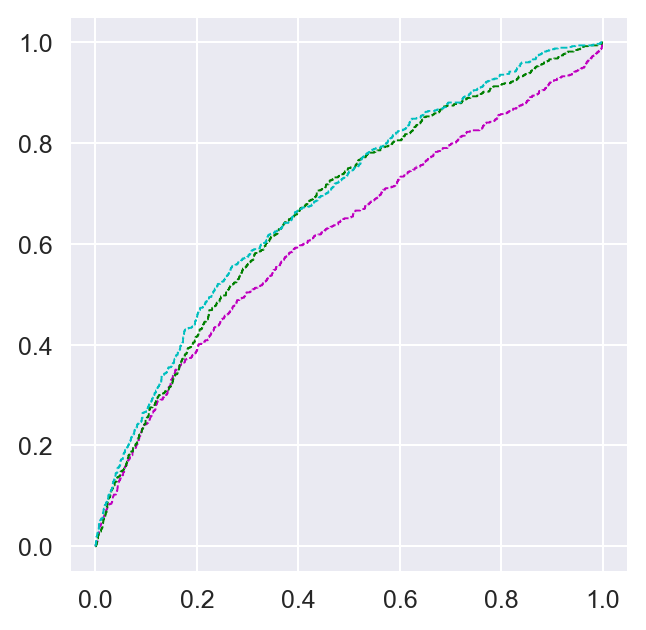

In [6]:
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)

In [7]:
from src.baselines import plot_related_baseline_roc

Text(0.5, 1.0, 'Baseline ROCs on IBEL')

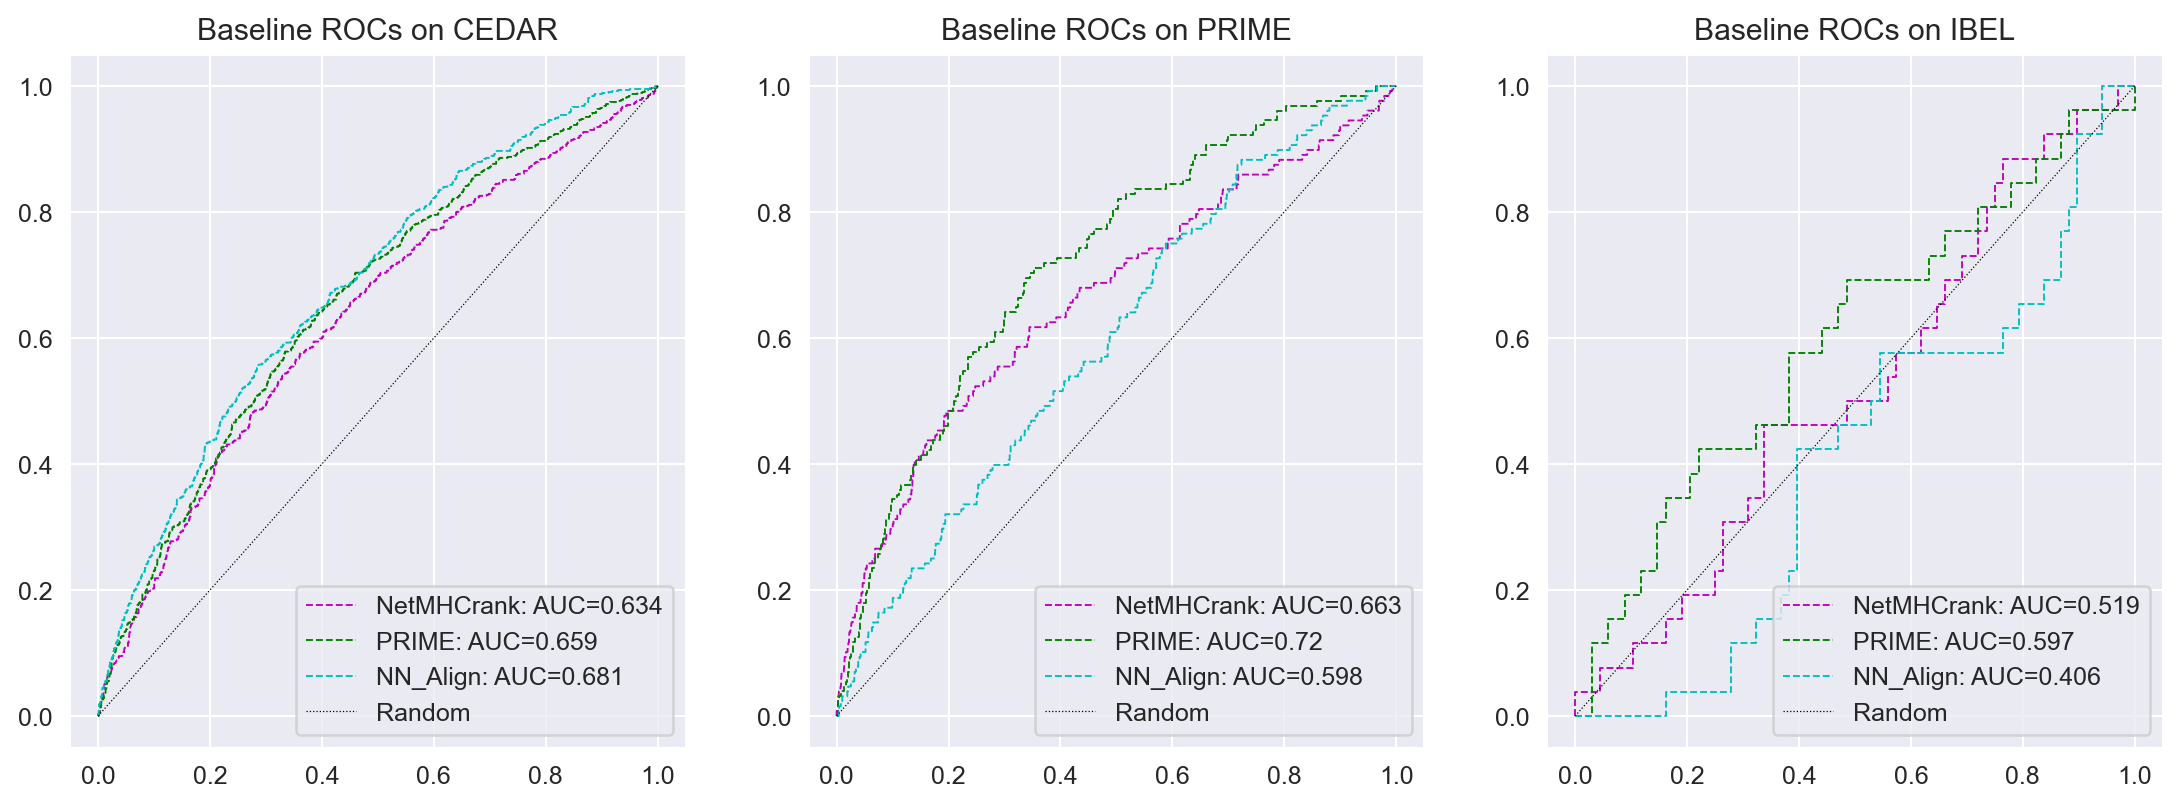

In [8]:
f,a = plt.subplots(1,3, figsize=(15,5))
plot_related_baseline_roc(axis=a[1], dataset=prime_related_baseline)
# a[1].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[1].legend(loc='lower right')
a[1].set_title('Baseline ROCs on PRIME')
plot_related_baseline_roc(axis=a[0], dataset=cedar_related_baseline)
# a[0].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[0].legend(loc='lower right')
a[0].set_title('Baseline ROCs on CEDAR')

plot_related_baseline_roc(axis=a[2], dataset=ibel)
# a[2].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[2].legend(loc='lower right')
a[2].set_title('Baseline ROCs on IBEL')

# Mutation scores recheck

IF YOU RE-READ THIS AT SOME POINT : I DID THIS AND NOTICED MY MUTATION SCORES WERE NOT SCORED PROPERLY FOR CEDAR SO I HAD TO REDO THEM AND SAVE AND REDO ALL THE SCRIPTS BECAUSE IM FUCKING STUPDI

## checking that I'm indeed dumb

In [36]:
from src.mutation_tools import get_blsm_mutation_score, get_mutation_score

In [39]:
cedar_related.mutation_score.describe()

count    3033.000000
mean        0.989306
std         0.476515
min        -1.000000
25%         0.693147
50%         0.693147
75%         1.386294
max         2.484907
Name: mutation_score, dtype: float64

In [53]:
cedar_related['blsm_mut_score'].describe()

count    3033.000000
mean       -0.802176
std         1.702406
min        -7.000000
25%        -2.000000
50%        -1.000000
75%         1.000000
max         5.000000
Name: blsm_mut_score, dtype: float64

In [62]:
[x for x in cedar_related.columns if '_score' in x]

['blsm_mut_score',
 'core_blsm_mut_score',
 'core_mutation_score',
 'dissimilarity_score',
 'mutation_score']

In [37]:
prime_redo = prime_related.copy()
cedar_redo = cedar_related.copy()

In [ ]:
cedar_related['mutation_score'] = cedar_related.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'],
                                                                                   x['wild_type']), axis=1)
cedar_related['blsm_mut_score'] = cedar_related.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'],
                                                                                   x['wild_type']), axis=1)
cedar_related['mutation_score'] = cedar_related.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'],
                                                                                   x['wild_type']), axis=1)
cedar_related['mutation_score'] = cedar_related.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'],
                                                                                   x['wild_type']), axis=1)

In [ ]:
prime_redo.core

In [65]:
prime_redo['mutation_score_redo'] = prime_redo.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'], 
                                                                             x['wild_type']), axis=1)
cedar_redo['mutation_score_redo'] = cedar_redo.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'], 
                                                                             x['wild_type']), axis=1)
prime_redo['blsm_mut_score_redo'] = prime_redo.apply(lambda x: get_blsm_mutation_score(x['mutation_position'], x['Peptide'], 
                                                                             x['wild_type']), axis=1)
cedar_redo['blsm_mut_score_redo'] = cedar_redo.apply(lambda x: get_blsm_mutation_score(x['mutation_position'], x['Peptide'], 
                                                                             x['wild_type']), axis=1)


#############
prime_redo['core_mutation_score_redo'] = prime_redo.apply(lambda x: get_mutation_score(x['core_mutation_position'], x['core_mut'], 
                                                                             x['core_wt']), axis=1)
cedar_redo['core_mutation_score_redo'] = cedar_redo.apply(lambda x: get_mutation_score(x['core_mutation_position'], x['core_mut'], 
                                                                             x['core_wt']), axis=1)
prime_redo['core_blsm_mut_score_redo'] = prime_redo.apply(lambda x: get_blsm_mutation_score(x['core_mutation_position'], x['core_mut'], 
                                                                             x['core_wt']), axis=1)
cedar_redo['core_blsm_mut_score_redo'] = cedar_redo.apply(lambda x: get_blsm_mutation_score(x['core_mutation_position'], x['core_mut'], 
                                                                             x['core_wt']), axis=1)


In [ ]:
pd.read_csv('../data/mutant/

In [48]:
cedar_redo['mut_score_redo'].describe()

count    3033.000000
mean        2.995054
std         1.407074
min         0.000000
25%         2.000000
50%         2.000000
75%         4.000000
max        12.000000
Name: mut_score_redo, dtype: float64

In [75]:
for score in ['mutation_score', 'blsm_mut_score', 'core_mutation_score', 'core_blsm_mut_score']:
    print(cedar_related[score].describe().equals(cedar_redo[score+'_redo'].describe()))

True
True
True
True


## RESAVING DATASETS (CEDAR & MERGED)

agg_label
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
Name: mutation_score, dtype: object

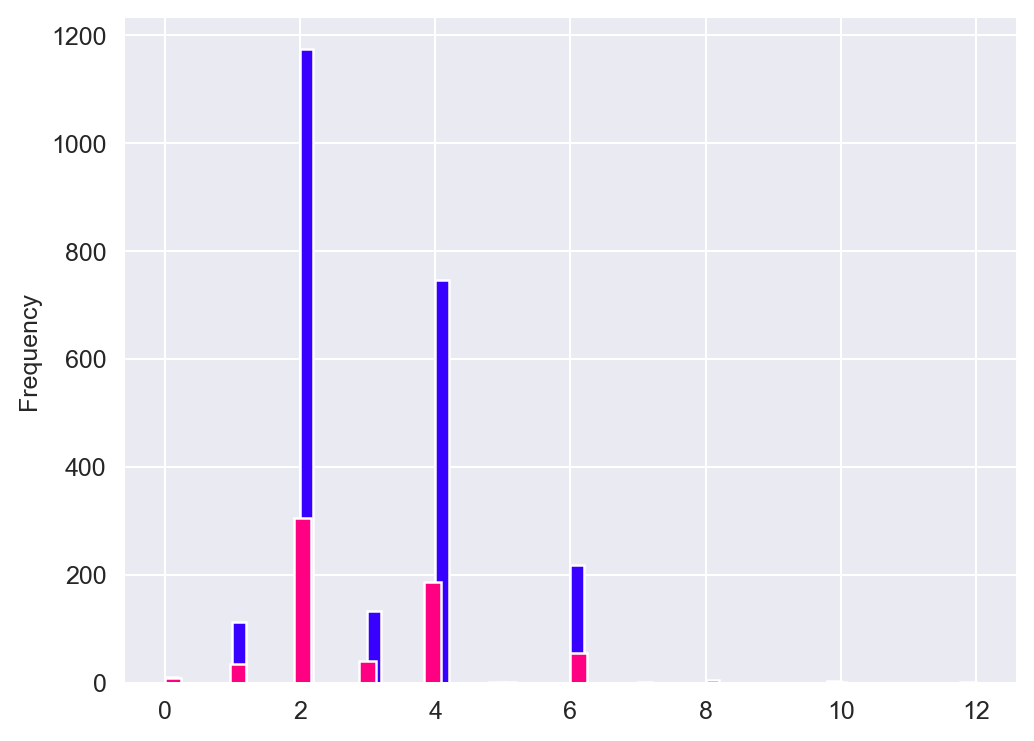

In [79]:
cedar_related.groupby('agg_label').mutation_score.plot(kind='hist', bins=50)

agg_label
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
Name: mutation_score, dtype: object

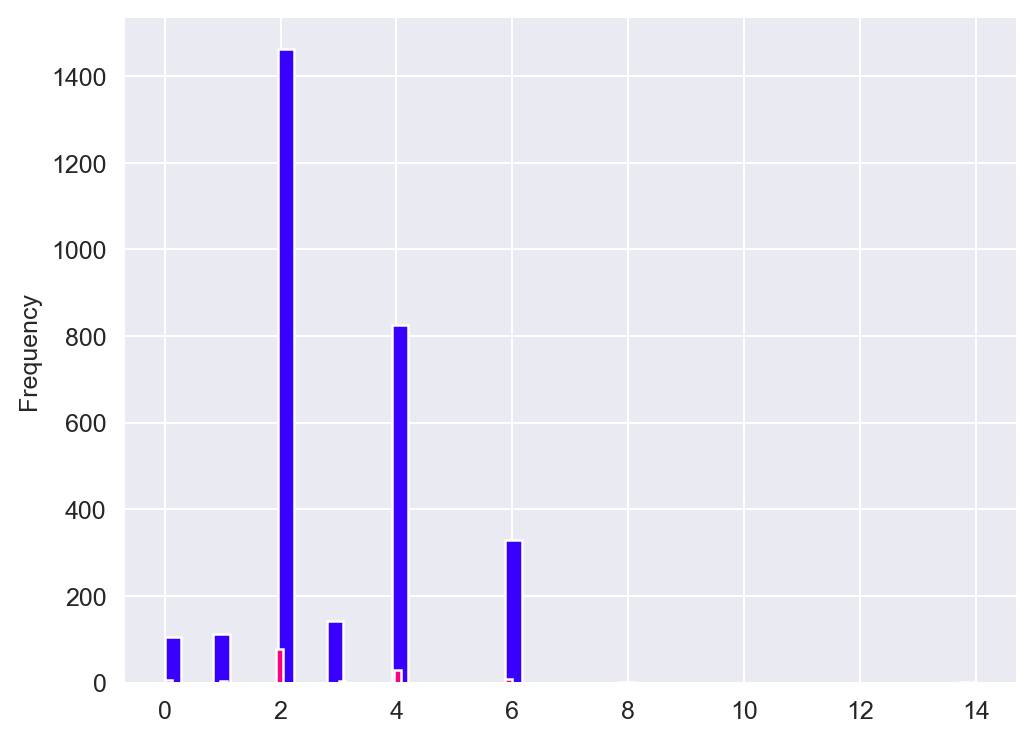

In [80]:
prime_related.groupby('agg_label').mutation_score.plot(kind='hist', bins=50)

In [81]:
# Overwritting old stupid wrong dataset
cedar_related.to_csv('../data/mutant/221028_cedar_related_newcore_fold.csv', index=False)


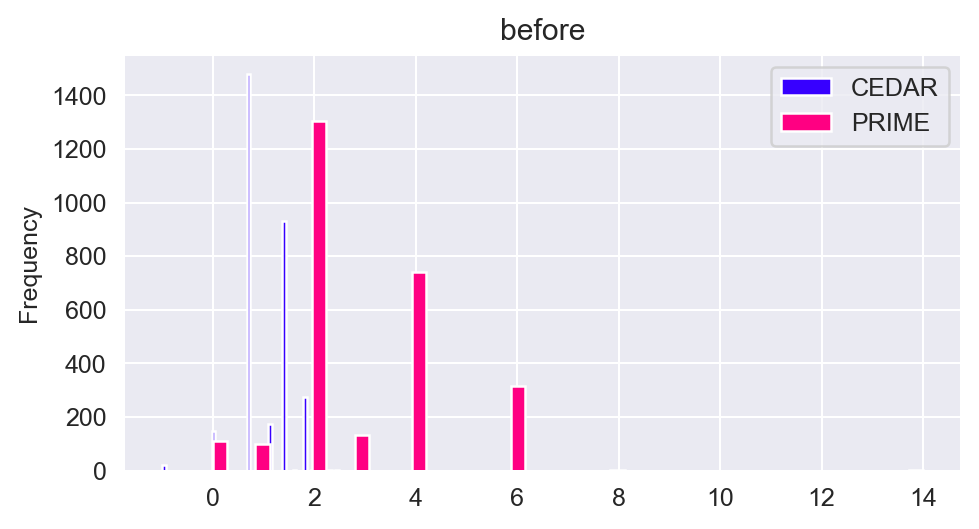

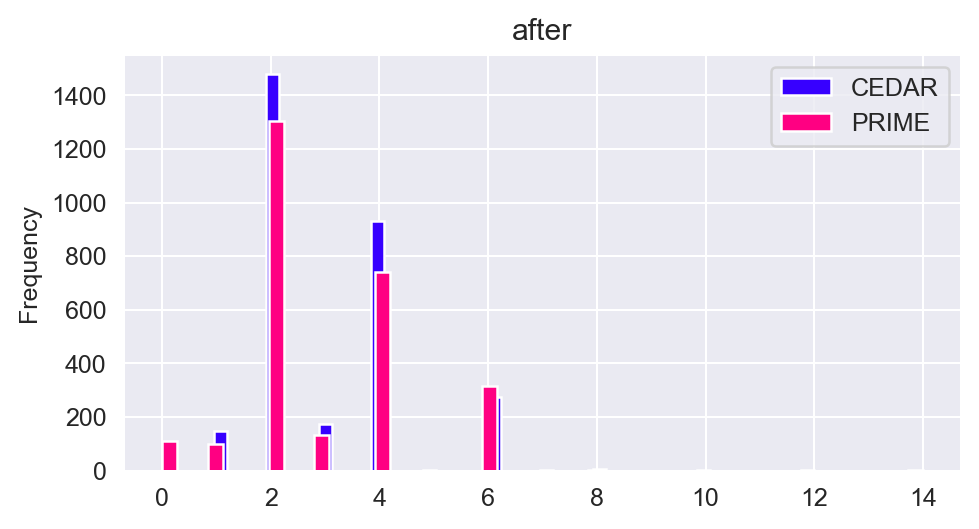

In [87]:
cedar_idx = cedar_prime_merged.query('dataset=="CEDAR"').index
f,a =plt.subplots(1,1,figsize=(6,3))
a.set_title('before')
cedar_prime_merged.groupby('dataset').mutation_score.plot(kind='hist', bins=50, ax = a)
a.legend()
cedar_prime_merged.loc[cedar_idx, 'mutation_score']=cedar_related['mutation_score'].values
f,a =plt.subplots(1,1,figsize=(6,3))
a.set_title('after')
cedar_prime_merged.groupby('dataset').mutation_score.plot(kind='hist', bins=50, ax = a)
a.legend()


In [88]:
cedar_prime_merged.to_csv('../data/mutant/221112_cedar_prime_merged_fold.csv', index=False)

# Retrain best params (221125)

## Retrain on CEDAR

In [17]:
from copy import deepcopy
from src.data_processing import AA_KEYS
_, props_col = get_aa_properties(cedar_related.sample(10))

encoding_kwargs={'encoding':'onehot',
 'blosum_matrix':None,
 'max_len':12,
 'add_rank':True,
 'mask':False,
 'add_aaprop':False,
 'remove_pep':False,
 'standardize':True,
 'target_col':'agg_label'}

outdir = '../output/trained_models/cedar/'
best_cedar='Inverted-KLXXPeptideXXEL_rank_mutXXaa_props'
best_prime='MaskXXPeptideXXEL_rank_mutXXcore_blsm_mut_score-core_mutation_score'
best_mean='MaskXXPeptideXXEL_rank_mutXXdissimilarity_score-core_blsm_mut_score-core_mutation_score'
best_weighted='KLXXicore_mutXXEL_rank_mutXXdissimilarity_score-blsm_mut_score'

best_kwarg_cedar = deepcopy(encoding_kwargs)
best_kwarg_prime = deepcopy(encoding_kwargs)
best_kwarg_mean = deepcopy(encoding_kwargs)
best_kwarg_weighted = deepcopy(encoding_kwargs)

filtered_cedar_all_results = {}
filtered_prime_all_results = {}
filtered_ibel_all_results = {}
for name, params, kwargs in zip(['best_cedar','best_prime','best_mean','best_weighted'],
                                [best_cedar, best_prime, best_mean, best_weighted],
                                [best_kwarg_cedar, best_kwarg_prime, best_kwarg_mean, best_kwarg_weighted]):
    params = params.split('XX')
    ic = ics_shannon if 'Mask' in params[0] else ics_kl
    kwargs['invert'] = True if 'Inverted' in params[0] else False
    kwargs['seq_col'] = params[1]
    kwargs['rank_col'] = params[2]
    kwargs['mut_col'] = params[3].split('-') if params[3] != 'aa_props' else props_col
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                   max_depth=8, ccp_alpha=9.945e-6)
    os.makedirs(f'{outdir}{name}/', exist_ok=True)
    # model = XGBClassifier(n_jobs=1, n_estimators=300, max_depth=8, reg_alpha=1e-3, reg_lambda=1e-2, random_state=13)
    print('Training')
    trained_models, train_metrics, _ = nested_kcv_train_mut(cedar_related, model,
                                                            ics_dict=ic,
                                                            encoding_kwargs=kwargs,
                                                            n_jobs=8)
    
    fi = get_nested_feature_importance(trained_models)
    fn = AA_KEYS + ['rank'] + kwargs['mut_col']
    # Saving Feature importances as dataframe
    df_fi = pd.DataFrame(fi, index=fn).T
    df_fi.to_csv(f'{outdir}{name}/featimps_{name}.csv', index=False)
    pkl_dump(trained_models, f'{outdir}{name}/models_{name}.pkl')
    pkl_dump(kwargs, f'{outdir}{name}/kwargs_{name}.pkl')
    with open(f'{outdir}{name}/params_{name}.txt', 'w') as f:
        for k,v in kwargs.items():
            f.write(f'{k}:\t{v}\n')
    

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

../output/trained_models/cedar/best_cedar/models_best_cedar.pkl saved.
../output/trained_models/cedar/best_cedar/kwargs_best_cedar.pkl saved.
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

../output/trained_models/cedar/best_prime/models_best_prime.pkl saved.
../output/trained_models/cedar/best_prime/kwargs_best_prime.pkl saved.
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

../output/trained_models/cedar/best_mean/models_best_mean.pkl saved.
../output/trained_models/cedar/best_mean/kwargs_best_mean.pkl saved.
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

../output/trained_models/cedar/best_weighted/models_best_weighted.pkl saved.
../output/trained_models/cedar/best_weighted/kwargs_best_weighted.pkl saved.


In [19]:
from copy import deepcopy
from src.data_processing import AA_KEYS
_, props_col = get_aa_properties(cedar_related.sample(10))

encoding_kwargs={'encoding':'onehot',
 'blosum_matrix':None,
 'max_len':12,
 'add_rank':True,
 'mask':False,
 'add_aaprop':False,
 'remove_pep':False,
 'standardize':True,
 'target_col':'agg_label'}

outdir='../output/trained_models/merged/'
best_cedar='Inverted-KLXXPeptideXXEL_rank_mutXXaa_props'
best_prime='MaskXXPeptideXXEL_rank_mutXXcore_blsm_mut_score-core_mutation_score'
best_merged='ShannonXXicore_mutXXEL_rank_mutXXdissimilarity_score-blsm_mut_score-mutation_score'
best_mean='ShannonXXPeptideXXEL_rank_mutXXblsm_mut_score-mutation_score'
best_weighted='ShannonXXicore_mutXXEL_rank_mutXXblsm_mut_score-mutation_score'

best_kwarg_cedar = deepcopy(encoding_kwargs)
best_kwarg_prime = deepcopy(encoding_kwargs)
best_kwarg_merged = deepcopy(encoding_kwargs)
best_kwarg_mean = deepcopy(encoding_kwargs)
best_kwarg_weighted = deepcopy(encoding_kwargs)

for name, params, kwargs in zip(['best_cedar','best_prime', 'best_merged', 'best_mean','best_weighted'],
                                [best_cedar, best_prime, best_merged, best_mean, best_weighted],
                                [best_kwarg_cedar, best_kwarg_prime, best_kwarg_merged,  best_kwarg_mean, best_kwarg_weighted]):
    params = params.split('XX')
    os.makedirs(f'{outdir}{name}/', exist_ok=True)
    ic = ics_shannon if 'Mask' in params[0] else ics_kl
    kwargs['invert'] = True if 'Inverted' in params[0] else False
    kwargs['seq_col'] = params[1]
    kwargs['rank_col'] = params[2]
    kwargs['mut_col'] = params[3].split('-') if params[3] != 'aa_props' else props_col
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=5, n_estimators=300,
                                   max_depth=8, ccp_alpha=9.945e-6)
    
    # model = XGBClassifier(n_jobs=1, n_estimators=300, max_depth=8, reg_alpha=1e-1, reg_lambda=1e-6, random_state=13)
    print('Training')
    trained_models, train_metrics, _ = nested_kcv_train_mut(cedar_prime_merged, model,
                                                            ics_dict=ic,
                                                            encoding_kwargs=kwargs,
                                                            n_jobs=8)
    
    fi = get_nested_feature_importance(trained_models)
    fn = AA_KEYS + ['rank'] + kwargs['mut_col']
    # Saving Feature importances as dataframe
    df_fi = pd.DataFrame(fi, index=fn).T
    df_fi.to_csv(f'{outdir}{name}/featimps_{name}.csv', index=False)
    pkl_dump(trained_models, f'{outdir}{name}/models_{name}.pkl')
    pkl_dump(kwargs, f'{outdir}{name}/kwargs_{name}.pkl')
    with open(f'{outdir}{name}/params_{name}.txt', 'w') as f:
        for k,v in kwargs.items():
            f.write(f'{k}:\t{v}\n')
    

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

../output/trained_models/merged/best_cedar/models_best_cedar.pkl saved.
../output/trained_models/merged/best_cedar/kwargs_best_cedar.pkl saved.
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

../output/trained_models/merged/best_prime/models_best_prime.pkl saved.
../output/trained_models/merged/best_prime/kwargs_best_prime.pkl saved.
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

../output/trained_models/merged/best_merged/models_best_merged.pkl saved.
../output/trained_models/merged/best_merged/kwargs_best_merged.pkl saved.
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

../output/trained_models/merged/best_mean/models_best_mean.pkl saved.
../output/trained_models/merged/best_mean/kwargs_best_mean.pkl saved.
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

../output/trained_models/merged/best_weighted/models_best_weighted.pkl saved.
../output/trained_models/merged/best_weighted/kwargs_best_weighted.pkl saved.


In [31]:
fi.values.flatten()

array([0.02258091, 0.019267  , 0.01310315, 0.01962822, 0.0079379 ,
       0.01513336, 0.01839013, 0.01779711, 0.02708337, 0.0507026 ,
       0.05167525, 0.02101094, 0.03274634, 0.05461197, 0.02152873,
       0.03726614, 0.02613008, 0.01640492, 0.04847504, 0.03954746,
       0.14906797, 0.05138015, 0.02340955, 0.21512171])

(<Figure size 1260x1080 with 1 Axes>,
 <AxesSubplot:title={'center':'Feature improtance for best "merged" model'}, xlabel='Percentage importance [%]', ylabel='Feature name'>)

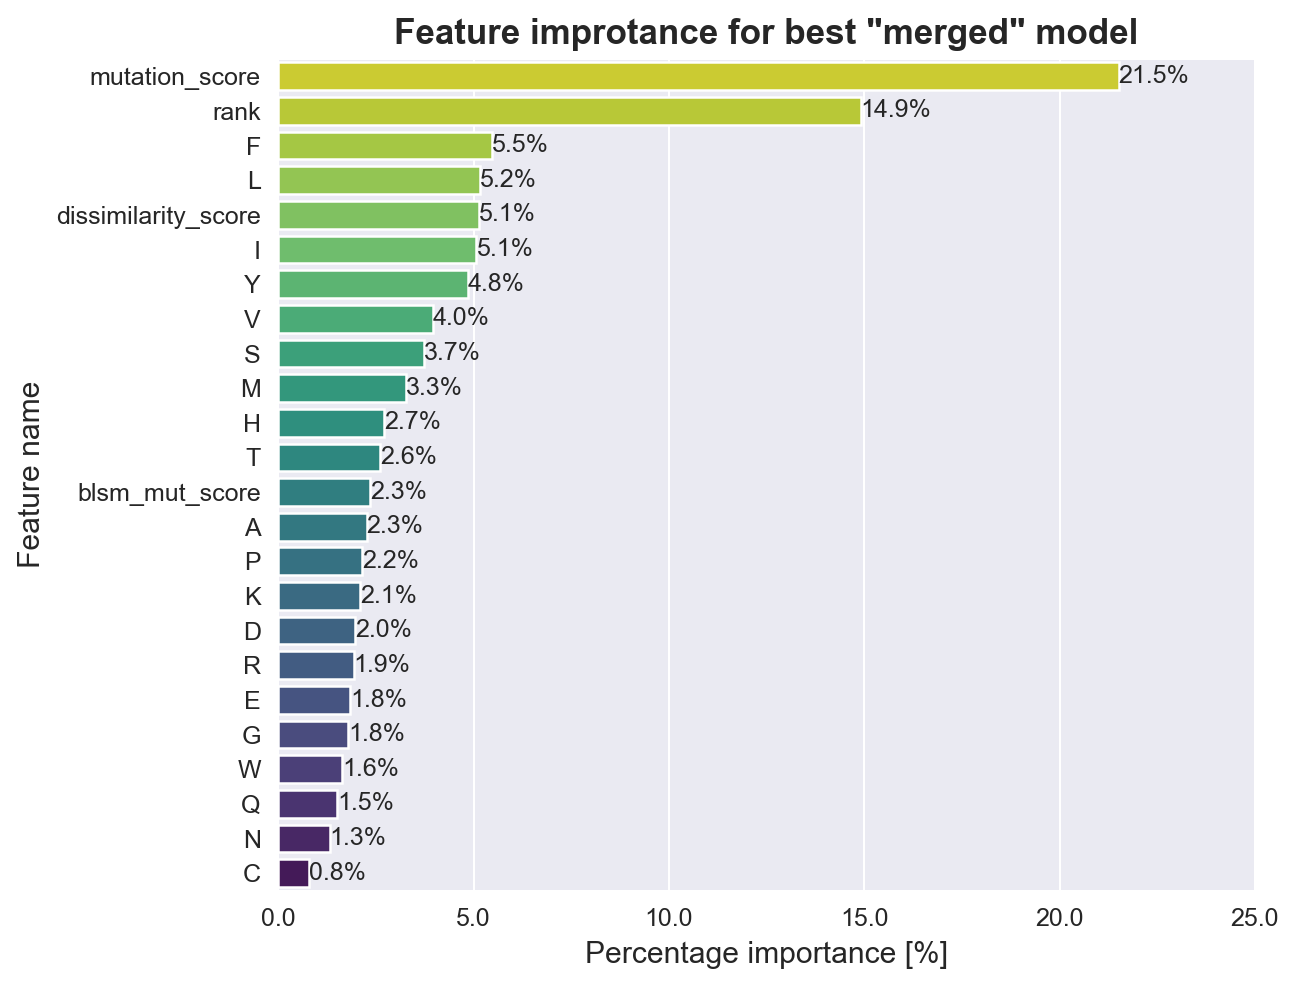

In [33]:
fi = pd.read_csv('../output/trained_models/merged/best_merged/featimps_best_merged.csv')
plot_feature_importance(fi.values.flatten(), fi.columns, title='Feature improtance for best "merged" model', label_number=True)

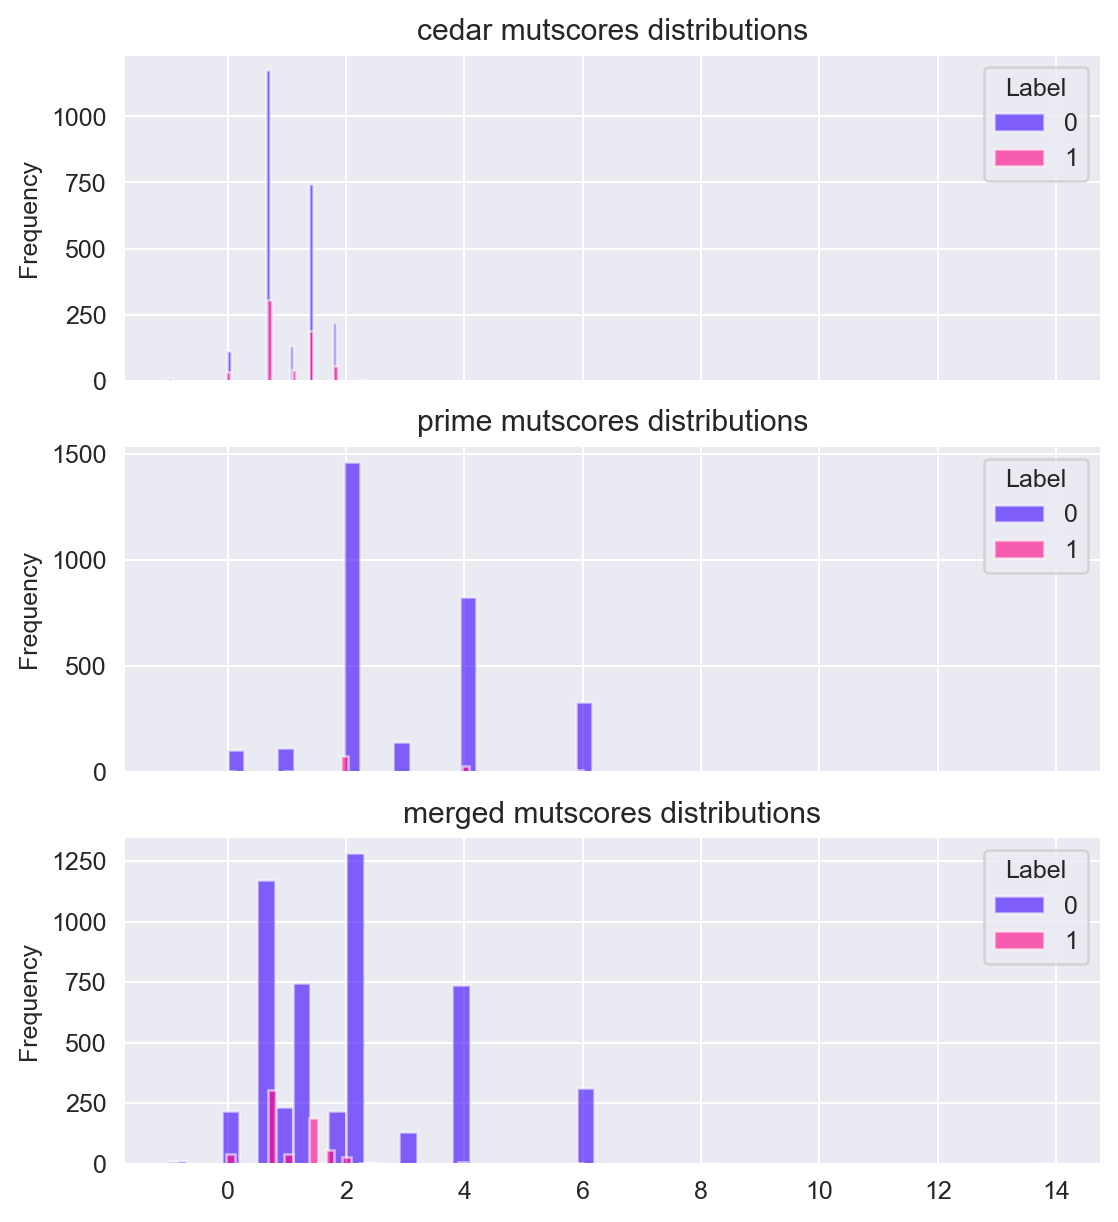

In [52]:
f,a = plt.subplots(3,1,figsize=(7, 8), sharex=True)
sns.set_palette(HSV)
x = ['cedar', 'prime', 'merged']
cedar_redo['mutation_score']=cedar_redo['mut_score_redo']
for i, df in enumerate([cedar_related, prime_related, cedar_prime_merged]):
    df.groupby('agg_label')['mutation_score'].plot(kind='hist', bins=50, ax=a[i], alpha=0.6)
    a[i].legend(title='Label')
    a[i].set_title(f'{x[i]} mutscores distributions')

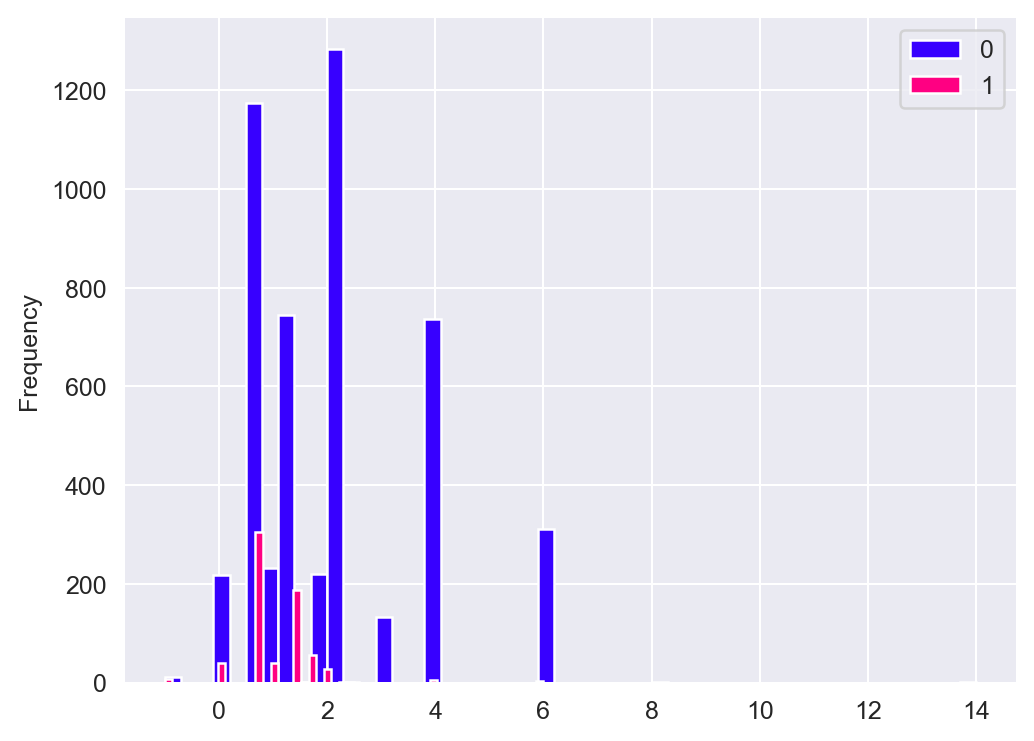

In [22]:
cedar_prime_merged.groupby('agg_label')['mutation_score'].plot(kind='hist', bins=50)
plt.legend()